In this notebook, we will train a neural network to classify Reuters Newswires between 46 classes.
The notebook is divided into as follow :

- Libraries import
- Defining some utilities functions that will be helpful during training
- Data loading & processing
- Model defining : which neural network to use ?
- Model evaluation

#### Importing libraries

We import in the following cells some libraries necessary for our lab. Some are deep learning dedicated libraries while other are more common python libraries.

In [0]:
# Deep Learning Framework
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import reuters
from tensorflow.keras.optimizers import RMSprop, Adam

In [0]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

#### Defining some utils

Below, we define some utils functions (mostly visualisation tools) helpful for the understanding of the process.

In [0]:
from IPython.display import clear_output
class TrainingPlot(tf.keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()]) # Reversed dictionary

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
  

Downloading data from https://storage.googleapis.com/tensorflow/tf-keras-datasets/reuters_word_index.json
 8192/550378 [..............................] - ETA: 0s516096/550378 [===========================>..] - ETA: 0s557056/550378 [==============================] - 0s 0us/step

### Part 1 : Data exploration

In the following cells, we prepare the data to be fed to a neural network to classify.

Our dataset is integrated in the deep learning package that we previously loaded. So the extraction is quite easy.

In [0]:
# Part 1: Data Preparation
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(path="reuters.npz", num_words=10000)

Downloading data from https://storage.googleapis.com/tensorflow/tf-keras-datasets/reuters.npz
 8192/2110848 [..............................] - ETA: 0s 155648/2110848 [=>............................] - ETA: 0s1351680/2110848 [==================>...........] - ETA: 0s2113536/2110848 [==============================] - 0s 0us/step

We loaded 11228 articles. 80% of the articles (8982) are used to train the neural network and the 20% remaining (2246) for testing.
The train-test proportions are often in this rank : 70/30 or 80/20. By default, here it is 80/20.


Some preprocessing was done by the library on the data. 

"Each newswire is encoded as a list of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word." (Keras)


To better understand the data, we decoded the labels below.

In [0]:
# Labels mapping  
reuters_labels = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
              'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
              'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
              'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
              'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']
dict_labels = dict(zip(np.arange(len(reuters_labels)), reuters_labels))
print(f'Labels are encoded as followed : \n {dict_labels}')

Labels are encoded as followed : 
 {0: 'cocoa', 1: 'grain', 2: 'veg-oil', 3: 'earn', 4: 'acq', 5: 'wheat', 6: 'copper', 7: 'housing', 8: 'money-supply', 9: 'coffee', 10: 'sugar', 11: 'trade', 12: 'reserves', 13: 'ship', 14: 'cotton', 15: 'carcass', 16: 'crude', 17: 'nat-gas', 18: 'cpi', 19: 'money-fx', 20: 'interest', 21: 'gnp', 22: 'meal-feed', 23: 'alum', 24: 'oilseed', 25: 'gold', 26: 'tin', 27: 'strategic-metal', 28: 'livestock', 29: 'retail', 30: 'ipi', 31: 'iron-steel', 32: 'rubber', 33: 'heat', 34: 'jobs', 35: 'lei', 36: 'bop', 37: 'zinc', 38: 'orange', 39: 'pet-chem', 40: 'dlr', 41: 'gas', 42: 'silver', 43: 'wpi', 44: 'hog', 45: 'lead'}

##### Example of a newswire

In [0]:
### you can change the newswire item number to view other newswire snippets
newswire_item = 100
print(f'Example of a newswire snippet of label {dict_labels[train_labels[newswire_item]].upper()} : \n\n {decode_review(train_data[newswire_item])}')

Example of a newswire snippet of label INTEREST : 

 the being legal into one per states will agriculture financial for computer economy first said sources 000 for consumer of recommendations 24 declined of facility metric mln increase a for encourage and for who sector cut of being deodorised a concluded reason qtly facility metric mln being legal in into second about states will improving ministers icco 3 states will defend financial for computer economy first said sources 000 last net david by wholly said in sources end for consumer subsidiary share revenue pigs it being 87 plan share sales transfer and lyons' their 3 net david by 22 downwards be being analysts over 1986 will prompted a no expanding it being and anticipated in into one first with action cts west percentage in counselor subsidiary said sources 000 for consumer at bond 87 bank share and lie meal pigs a of their facility metric mln 22 downwards measure a plant expanding will prompted facility metric mln loss canadian loss american 3 continued push no analysts 326 that delayed june same it take 34 3 one downwards share tuesday 418 june 76 net six facility metric many by rose being same u monetary in pioneer's imports aluminium it rates bond 87 a if real are share foster riyadh in senior said forecast riyadh foster by shares venture weekend upland and for show subsidiary u likely month pacific facility metric mln for 529 venture a in into shares attention for 628 prove said there involved net six net mln no grain being one discount 87 share owners for immediately seemed more but and nor was being last real downwards long be forecast analysts oil article america 3 maturity be being stock oil 418 a nil said cotton net six in place representatives said grain being 80 bank 1986 southmark accelerating and lme hope it 60 maryland net mln facility metric mln not sources end for consumer first u counselor loss 1 shortage due a in one when intent being and south 14 1986 jorge providing agreed largely it stanley of term industries reduced intent being 22 for first 5 50 air sectors coal late net six of facility effected being determined declined 24 two arctic in deodorised six by 587 u likely allow and slow of always a in one shares involved stg relatively analysts 3 pretax u bars it day upon facility effected mln bankers net refined involved 5 democrats special and sold of of relatively lies pct dlrs

We can see that this text is not quite understable. The dataset was preprocessed to only contain the top 10K words of the dictionnary.

##### Label distribution in the train & test datasets

Out[7]:

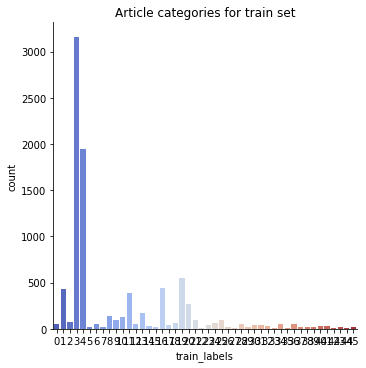

<seaborn.axisgrid.FacetGrid at 0x7f4ab8471310>

In [0]:
df_train_labels = pd.DataFrame(data=train_labels, columns=["train_labels"])
df_train_labels["train_labels"]= pd.Categorical(df_train_labels.train_labels )
sns.color_palette("coolwarm", 7)
ax = sns.catplot(x="train_labels", kind="count", data = df_train_labels, palette = "coolwarm")
ax.set(title = "Article categories for train set")

Most articles in the training dataset cover the genre 3 & 4, respectively Earn & Acq.

Out[8]:

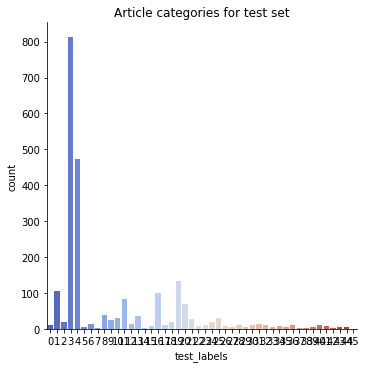

<seaborn.axisgrid.FacetGrid at 0x7f4a8db16d90>

In [0]:
df_test_labels = pd.DataFrame(data=test_labels, columns=["test_labels"])
df_test_labels["test_labels"]= pd.Categorical(df_test_labels.test_labels )
sns.color_palette("coolwarm", 7)
ax = sns.catplot(x="test_labels", kind="count", data = df_test_labels, palette = "coolwarm")
ax.set(title = "Article categories for test set")

As we can see above, the test set follows the same distribution as the training set.
It is important for the training and test sets to approximatively follow the same distribution, because the neural network (NN) can not predict items that it never saw. 

** -> To train a NN, it is important to give it enough examples of each label, for it to be able to recognize & predict alike items.**

#### Vectorization

By vectorizing with One Hot Encoding (OHE), we describe each newswire by the presence or absence of the words in the vocabulary. It gives a sparse matrix, since every word can not be in every newswire.

We consider that we have a vocabulary composed of 10k words. Each article is vectorized (pre-processing) before being fed to the neural network.

In [0]:
def vectorize_sequences(X, ndim = 10001):
    results = []
    for i in X:
        seq = np.zeros(ndim)
        seq[list(set(i))] = 1
        results.append(seq)
    return np.vstack(results)[:,1:]


In [0]:
## Use one-hot encoding
train_data_vec, test_data_vec = vectorize_sequences(train_data), vectorize_sequences(test_data)

## Prepare labels
train_labels_vec,test_labels_vec = tf.keras.utils.to_categorical(train_labels), tf.keras.utils.to_categorical(test_labels)

print(f' After vectorizing, we have a very sparse training matrix with majority of 0 and only {100*np.size(np.where(train_data_vec != 0))/ np.size(train_data_vec)}% non zero.')

After vectorizing, we have a very sparse training matrix with majority of 0 and only 1.6333043865508796% non zero.

## Part 2: Model Definition

In [0]:

## Define the network

# Dense(64) is a fully-connected layer with 64 hidden units.
model = Sequential()
model.add(Dense(64, activation='relu',input_dim=10000))
model.add(Dense(64, activation='relu'))
model.add(Dense(46, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
## View a summary of the network
#model.__dict__

Validation set

- We use a validation set while training to ensure that the model is able to generalize & does not overfit on training data.

- Using a validation set is also a good way to detect the moment when to stop training.

In [0]:
## Validation set
index = 1000

val_data_vec,train_data_vec = train_data_vec[:index,:], train_data_vec[index:,:]
val_labels_vec,train_labels_vec = train_labels_vec[:index,:], train_labels_vec[index:,:]

Epoch 1/20
 1/16 [>.............................] - ETA: 0s - loss: 3.8286 - accuracy: 0.0254 3/16 [====>.........................] - ETA: 0s - loss: 3.6336 - accuracy: 0.3424 5/16 [========>.....................] - ETA: 0s - loss: 3.3995 - accuracy: 0.4270 7/16 [============>.................] - ETA: 0s - loss: 3.2007 - accuracy: 0.4646 9/16 [===============>..............] - ETA: 0s - loss: 3.0463 - accuracy: 0.481811/16 [===================>..........] - ETA: 0s - loss: 2.9014 - accuracy: 0.493813/16 [=======================>......] - ETA: 0s - loss: 2.7800 - accuracy: 0.505615/16 [===========================>..] - ETA: 0s - loss: 2.6599 - accuracy: 0.520716/16 [==============================] - 1s 44ms/step - loss: 2.6318 - accuracy: 0.5231 - val_loss: 1.7456 - val_accuracy: 0.6260
Epoch 2/20
 1/16 [>.............................] - ETA: 0s - loss: 1.6119 - accuracy: 0.6797 3/16 [====>.........................] - ETA: 0s - loss: 1.5711 - accuracy: 0.6732 6/16 [==========>...................] - ETA: 0s - loss: 1.5338 - accuracy: 0.6761 9/16 [===============>..............] - ETA: 0s - loss: 1.5006 - accuracy: 0.681911/16 [===================>..........] - ETA: 0s - loss: 1.4730 - accuracy: 0.687513/16 [=======================>......] - ETA: 0s - loss: 1.4630 - accuracy: 0.688715/16 [===========================>..] - ETA: 0s - loss: 1.4378 - accuracy: 0.6947

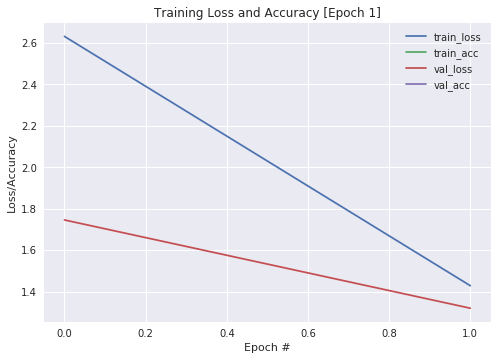

16/16 [==============================] - 1s 40ms/step - loss: 1.4281 - accuracy: 0.6958 - val_loss: 1.3195 - val_accuracy: 0.7190
Epoch 3/20
 1/16 [>.............................] - ETA: 0s - loss: 1.1309 - accuracy: 0.7637 4/16 [======>.......................] - ETA: 0s - loss: 1.1203 - accuracy: 0.7642 6/16 [==========>...................] - ETA: 0s - loss: 1.0971 - accuracy: 0.7686 8/16 [==============>...............] - ETA: 0s - loss: 1.0981 - accuracy: 0.766111/16 [===================>..........] - ETA: 0s - loss: 1.0759 - accuracy: 0.773414/16 [=========================>....] - ETA: 0s - loss: 1.0573 - accuracy: 0.7776

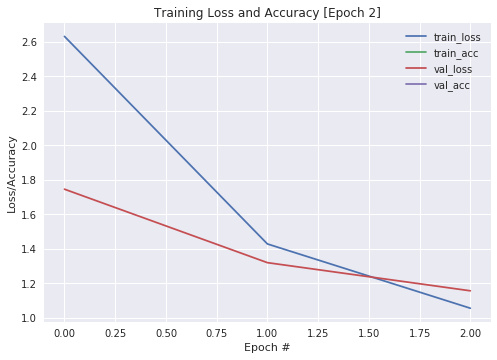

16/16 [==============================] - 1s 42ms/step - loss: 1.0552 - accuracy: 0.7780 - val_loss: 1.1562 - val_accuracy: 0.7520
Epoch 4/20
 1/16 [>.............................] - ETA: 0s - loss: 0.9423 - accuracy: 0.8027 3/16 [====>.........................] - ETA: 0s - loss: 0.8942 - accuracy: 0.8164 4/16 [======>.......................] - ETA: 0s - loss: 0.9034 - accuracy: 0.8125 5/16 [========>.....................] - ETA: 0s - loss: 0.8726 - accuracy: 0.8203 7/16 [============>.................] - ETA: 0s - loss: 0.8575 - accuracy: 0.8198 8/16 [==============>...............] - ETA: 0s - loss: 0.8455 - accuracy: 0.8218 9/16 [===============>..............] - ETA: 0s - loss: 0.8458 - accuracy: 0.821211/16 [===================>..........] - ETA: 0s - loss: 0.8422 - accuracy: 0.820713/16 [=======================>......] - ETA: 0s - loss: 0.8361 - accuracy: 0.821815/16 [===========================>..] - ETA: 0s - loss: 0.8318 - accuracy: 0.8236

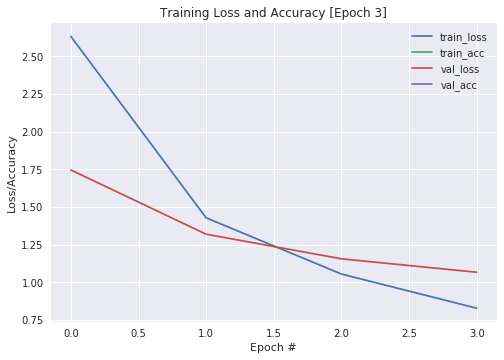

16/16 [==============================] - 1s 62ms/step - loss: 0.8284 - accuracy: 0.8242 - val_loss: 1.0671 - val_accuracy: 0.7680
Epoch 5/20
 1/16 [>.............................] - ETA: 0s - loss: 0.7305 - accuracy: 0.8379 3/16 [====>.........................] - ETA: 0s - loss: 0.6846 - accuracy: 0.8503 6/16 [==========>...................] - ETA: 0s - loss: 0.6811 - accuracy: 0.8551 8/16 [==============>...............] - ETA: 0s - loss: 0.6645 - accuracy: 0.859111/16 [===================>..........] - ETA: 0s - loss: 0.6524 - accuracy: 0.861314/16 [=========================>....] - ETA: 0s - loss: 0.6520 - accuracy: 0.8608

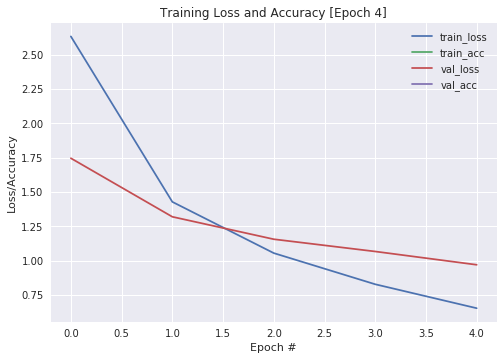

16/16 [==============================] - 1s 41ms/step - loss: 0.6543 - accuracy: 0.8598 - val_loss: 0.9703 - val_accuracy: 0.7980
Epoch 6/20
 1/16 [>.............................] - ETA: 0s - loss: 0.5780 - accuracy: 0.8867 4/16 [======>.......................] - ETA: 0s - loss: 0.5441 - accuracy: 0.8911 7/16 [============>.................] - ETA: 0s - loss: 0.5161 - accuracy: 0.8951 9/16 [===============>..............] - ETA: 0s - loss: 0.5248 - accuracy: 0.891312/16 [=====================>........] - ETA: 0s - loss: 0.5296 - accuracy: 0.892114/16 [=========================>....] - ETA: 0s - loss: 0.5271 - accuracy: 0.8923

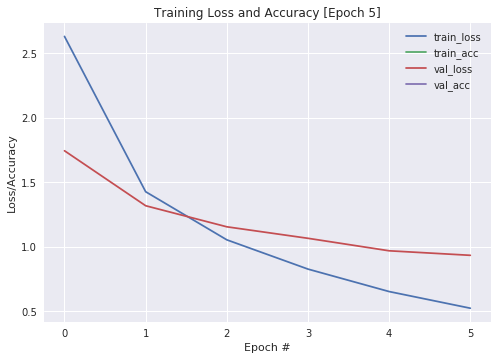

16/16 [==============================] - 1s 37ms/step - loss: 0.5253 - accuracy: 0.8924 - val_loss: 0.9353 - val_accuracy: 0.8000
Epoch 7/20
 1/16 [>.............................] - ETA: 0s - loss: 0.3538 - accuracy: 0.9219 3/16 [====>.........................] - ETA: 0s - loss: 0.3894 - accuracy: 0.9167 4/16 [======>.......................] - ETA: 0s - loss: 0.3951 - accuracy: 0.9180 6/16 [==========>...................] - ETA: 0s - loss: 0.4135 - accuracy: 0.9170 9/16 [===============>..............] - ETA: 0s - loss: 0.4094 - accuracy: 0.917812/16 [=====================>........] - ETA: 0s - loss: 0.4177 - accuracy: 0.914414/16 [=========================>....] - ETA: 0s - loss: 0.4171 - accuracy: 0.9145

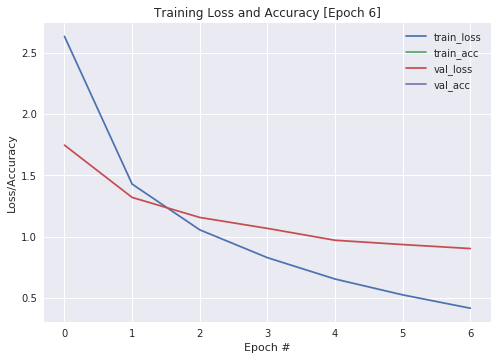

16/16 [==============================] - 1s 43ms/step - loss: 0.4164 - accuracy: 0.9141 - val_loss: 0.9027 - val_accuracy: 0.8110
Epoch 8/20
 1/16 [>.............................] - ETA: 0s - loss: 0.3047 - accuracy: 0.9531 3/16 [====>.........................] - ETA: 0s - loss: 0.3275 - accuracy: 0.9408 5/16 [========>.....................] - ETA: 0s - loss: 0.3269 - accuracy: 0.9398 7/16 [============>.................] - ETA: 0s - loss: 0.3230 - accuracy: 0.937510/16 [=================>............] - ETA: 0s - loss: 0.3252 - accuracy: 0.936112/16 [=====================>........] - ETA: 0s - loss: 0.3290 - accuracy: 0.934614/16 [=========================>....] - ETA: 0s - loss: 0.3292 - accuracy: 0.932916/16 [==============================] - ETA: 0s - loss: 0.3377 - accuracy: 0.9301

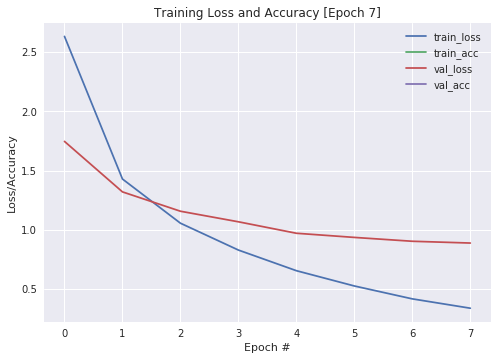

16/16 [==============================] - 1s 54ms/step - loss: 0.3377 - accuracy: 0.9301 - val_loss: 0.8877 - val_accuracy: 0.8230
Epoch 9/20
 1/16 [>.............................] - ETA: 0s - loss: 0.2576 - accuracy: 0.9512 3/16 [====>.........................] - ETA: 0s - loss: 0.2548 - accuracy: 0.9512 6/16 [==========>...................] - ETA: 0s - loss: 0.2754 - accuracy: 0.9453 8/16 [==============>...............] - ETA: 0s - loss: 0.2771 - accuracy: 0.943111/16 [===================>..........] - ETA: 0s - loss: 0.2771 - accuracy: 0.941914/16 [=========================>....] - ETA: 0s - loss: 0.2767 - accuracy: 0.9410

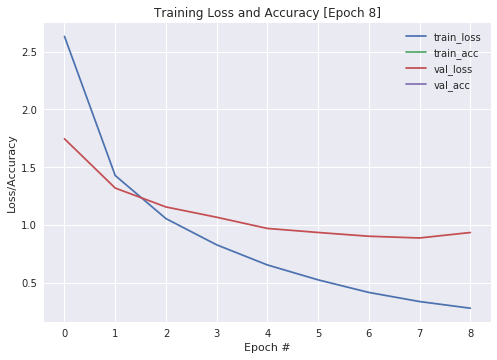

16/16 [==============================] - 1s 39ms/step - loss: 0.2800 - accuracy: 0.9394 - val_loss: 0.9349 - val_accuracy: 0.7980
Epoch 10/20
 1/16 [>.............................] - ETA: 0s - loss: 0.2567 - accuracy: 0.9551 3/16 [====>.........................] - ETA: 0s - loss: 0.2340 - accuracy: 0.9564 6/16 [==========>...................] - ETA: 0s - loss: 0.2260 - accuracy: 0.9544 9/16 [===============>..............] - ETA: 0s - loss: 0.2283 - accuracy: 0.954212/16 [=====================>........] - ETA: 0s - loss: 0.2341 - accuracy: 0.949515/16 [===========================>..] - ETA: 0s - loss: 0.2355 - accuracy: 0.9471

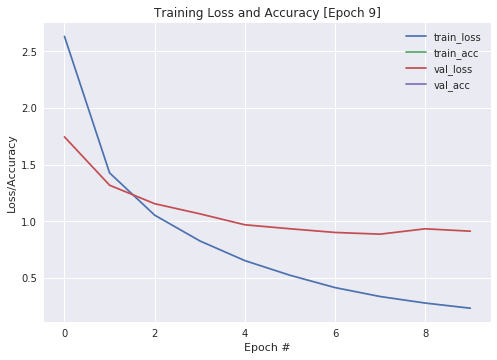

16/16 [==============================] - 1s 35ms/step - loss: 0.2346 - accuracy: 0.9471 - val_loss: 0.9139 - val_accuracy: 0.8040
Epoch 11/20
 1/16 [>.............................] - ETA: 0s - loss: 0.1959 - accuracy: 0.9531 4/16 [======>.......................] - ETA: 0s - loss: 0.1859 - accuracy: 0.9541 7/16 [============>.................] - ETA: 0s - loss: 0.1907 - accuracy: 0.952810/16 [=================>............] - ETA: 0s - loss: 0.1892 - accuracy: 0.954513/16 [=======================>......] - ETA: 0s - loss: 0.1980 - accuracy: 0.951815/16 [===========================>..] - ETA: 0s - loss: 0.2028 - accuracy: 0.9501

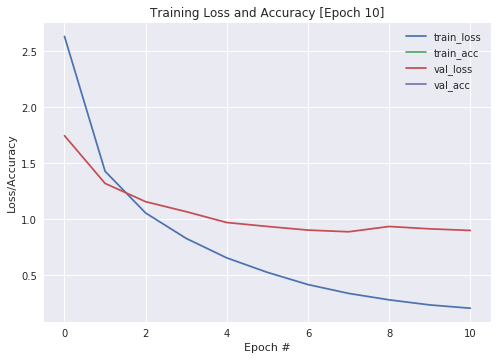

16/16 [==============================] - 1s 35ms/step - loss: 0.2053 - accuracy: 0.9496 - val_loss: 0.8995 - val_accuracy: 0.8160
Epoch 12/20
 1/16 [>.............................] - ETA: 0s - loss: 0.1618 - accuracy: 0.9648 4/16 [======>.......................] - ETA: 0s - loss: 0.1730 - accuracy: 0.9565 7/16 [============>.................] - ETA: 0s - loss: 0.1742 - accuracy: 0.955110/16 [=================>............] - ETA: 0s - loss: 0.1703 - accuracy: 0.955713/16 [=======================>......] - ETA: 0s - loss: 0.1721 - accuracy: 0.953916/16 [==============================] - ETA: 0s - loss: 0.1765 - accuracy: 0.9538

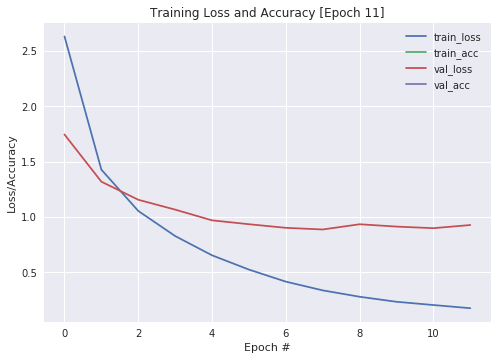

16/16 [==============================] - 1s 34ms/step - loss: 0.1765 - accuracy: 0.9538 - val_loss: 0.9279 - val_accuracy: 0.8070
Epoch 13/20
 1/16 [>.............................] - ETA: 0s - loss: 0.1343 - accuracy: 0.9629 4/16 [======>.......................] - ETA: 0s - loss: 0.1388 - accuracy: 0.9653 6/16 [==========>...................] - ETA: 0s - loss: 0.1406 - accuracy: 0.9655 9/16 [===============>..............] - ETA: 0s - loss: 0.1427 - accuracy: 0.961412/16 [=====================>........] - ETA: 0s - loss: 0.1512 - accuracy: 0.959315/16 [===========================>..] - ETA: 0s - loss: 0.1601 - accuracy: 0.9547

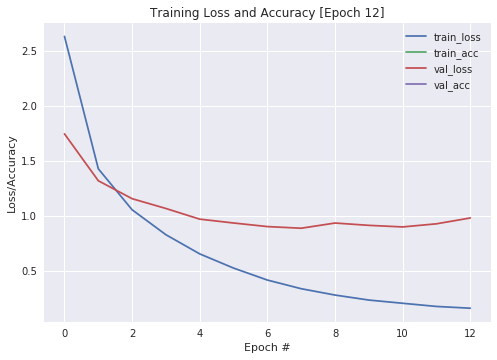

16/16 [==============================] - 1s 36ms/step - loss: 0.1605 - accuracy: 0.9544 - val_loss: 0.9811 - val_accuracy: 0.7940
Epoch 14/20
 1/16 [>.............................] - ETA: 0s - loss: 0.1603 - accuracy: 0.9531 3/16 [====>.........................] - ETA: 0s - loss: 0.1418 - accuracy: 0.9583 5/16 [========>.....................] - ETA: 0s - loss: 0.1337 - accuracy: 0.9605 7/16 [============>.................] - ETA: 0s - loss: 0.1369 - accuracy: 0.959010/16 [=================>............] - ETA: 0s - loss: 0.1406 - accuracy: 0.957813/16 [=======================>......] - ETA: 0s - loss: 0.1464 - accuracy: 0.955716/16 [==============================] - ETA: 0s - loss: 0.1468 - accuracy: 0.9557

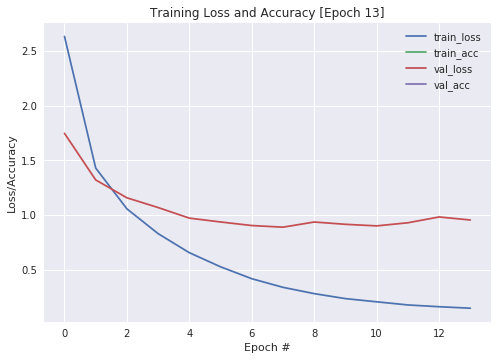

16/16 [==============================] - 1s 40ms/step - loss: 0.1468 - accuracy: 0.9557 - val_loss: 0.9534 - val_accuracy: 0.8100
Epoch 15/20
 1/16 [>.............................] - ETA: 0s - loss: 0.1039 - accuracy: 0.9688 4/16 [======>.......................] - ETA: 0s - loss: 0.1134 - accuracy: 0.9644 6/16 [==========>...................] - ETA: 0s - loss: 0.1194 - accuracy: 0.9635 8/16 [==============>...............] - ETA: 0s - loss: 0.1189 - accuracy: 0.962610/16 [=================>............] - ETA: 0s - loss: 0.1298 - accuracy: 0.958812/16 [=====================>........] - ETA: 0s - loss: 0.1281 - accuracy: 0.958815/16 [===========================>..] - ETA: 0s - loss: 0.1374 - accuracy: 0.9565

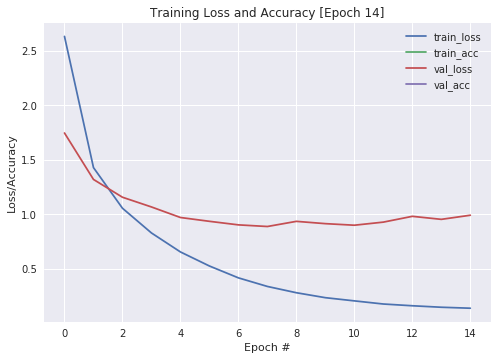

16/16 [==============================] - 1s 44ms/step - loss: 0.1380 - accuracy: 0.9565 - val_loss: 0.9911 - val_accuracy: 0.8040
Epoch 16/20
 1/16 [>.............................] - ETA: 0s - loss: 0.1413 - accuracy: 0.9629 4/16 [======>.......................] - ETA: 0s - loss: 0.1161 - accuracy: 0.9619 6/16 [==========>...................] - ETA: 0s - loss: 0.1145 - accuracy: 0.9642 9/16 [===============>..............] - ETA: 0s - loss: 0.1136 - accuracy: 0.964812/16 [=====================>........] - ETA: 0s - loss: 0.1212 - accuracy: 0.960915/16 [===========================>..] - ETA: 0s - loss: 0.1281 - accuracy: 0.9582

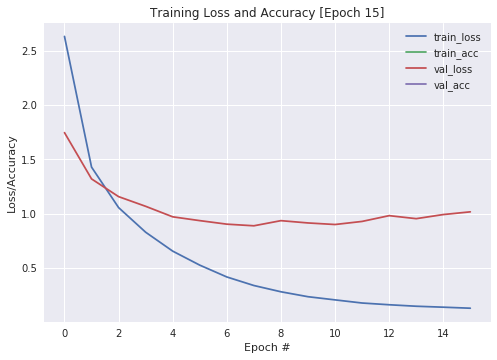

16/16 [==============================] - 1s 37ms/step - loss: 0.1287 - accuracy: 0.9577 - val_loss: 1.0162 - val_accuracy: 0.7970
Epoch 17/20
 1/16 [>.............................] - ETA: 0s - loss: 0.1045 - accuracy: 0.9688 3/16 [====>.........................] - ETA: 0s - loss: 0.0992 - accuracy: 0.9635 6/16 [==========>...................] - ETA: 0s - loss: 0.0990 - accuracy: 0.9632 9/16 [===============>..............] - ETA: 0s - loss: 0.1075 - accuracy: 0.961612/16 [=====================>........] - ETA: 0s - loss: 0.1131 - accuracy: 0.959515/16 [===========================>..] - ETA: 0s - loss: 0.1218 - accuracy: 0.9565

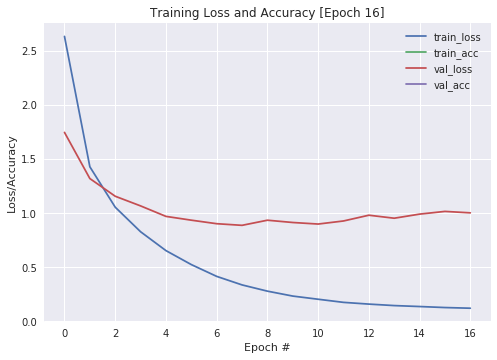

16/16 [==============================] - 1s 35ms/step - loss: 0.1226 - accuracy: 0.9562 - val_loss: 1.0029 - val_accuracy: 0.8080
Epoch 18/20
 1/16 [>.............................] - ETA: 0s - loss: 0.0756 - accuracy: 0.9785 4/16 [======>.......................] - ETA: 0s - loss: 0.0957 - accuracy: 0.9717 7/16 [============>.................] - ETA: 0s - loss: 0.1068 - accuracy: 0.963710/16 [=================>............] - ETA: 0s - loss: 0.1053 - accuracy: 0.962713/16 [=======================>......] - ETA: 0s - loss: 0.1175 - accuracy: 0.9602

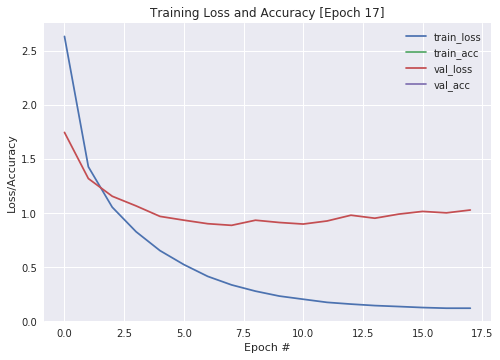

16/16 [==============================] - 1s 35ms/step - loss: 0.1226 - accuracy: 0.9572 - val_loss: 1.0292 - val_accuracy: 0.8040
Epoch 19/20
 1/16 [>.............................] - ETA: 0s - loss: 0.0772 - accuracy: 0.9707 4/16 [======>.......................] - ETA: 0s - loss: 0.0938 - accuracy: 0.9639 7/16 [============>.................] - ETA: 0s - loss: 0.1014 - accuracy: 0.9618 9/16 [===============>..............] - ETA: 0s - loss: 0.0972 - accuracy: 0.963112/16 [=====================>........] - ETA: 0s - loss: 0.1043 - accuracy: 0.960815/16 [===========================>..] - ETA: 0s - loss: 0.1098 - accuracy: 0.9586

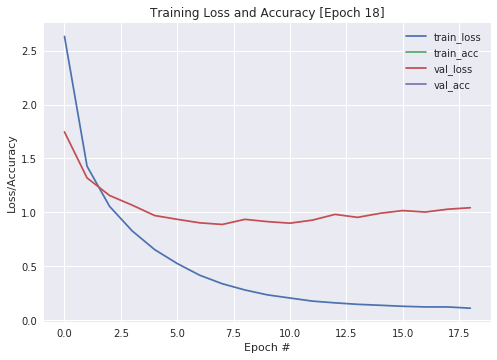

16/16 [==============================] - 1s 37ms/step - loss: 0.1108 - accuracy: 0.9580 - val_loss: 1.0428 - val_accuracy: 0.8030
Epoch 20/20
 1/16 [>.............................] - ETA: 0s - loss: 0.1209 - accuracy: 0.9551 4/16 [======>.......................] - ETA: 0s - loss: 0.0925 - accuracy: 0.9648 7/16 [============>.................] - ETA: 0s - loss: 0.1009 - accuracy: 0.961210/16 [=================>............] - ETA: 0s - loss: 0.1002 - accuracy: 0.961513/16 [=======================>......] - ETA: 0s - loss: 0.1067 - accuracy: 0.959716/16 [==============================] - ETA: 0s - loss: 0.1096 - accuracy: 0.9574

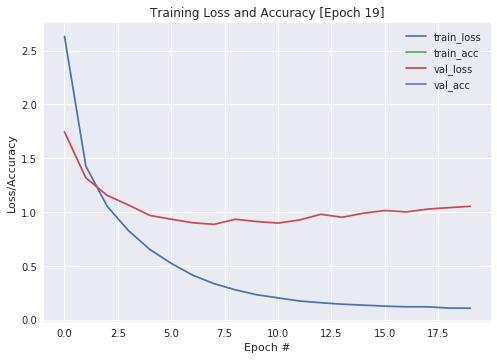

16/16 [==============================] - 1s 34ms/step - loss: 0.1096 - accuracy: 0.9574 - val_loss: 1.0550 - val_accuracy: 0.7990

In [0]:
## Train network
history = model.fit(train_data_vec, 
                    train_labels_vec,
                    epochs=20,
                    batch_size=512,
                    validation_data=(val_data_vec,val_labels_vec),
                    callbacks = [plot_losses])

We can see that the validation loss increases after 9 epochs, but the train loss keeps decreasing. We notice that the neural network is overfitting on the training data. So we decide to stop the training after 9 epochs.

What is an **epoch** ?

-> An epoch refers to **one cycle through the full training dataset**. Usually, training a neural network takes more than a few epochs. In other words, if we feed a neural network the training data for more than one epoch in different patterns, we hope for a better generalization when given a new "unseen" input (test data).

***https://deepai.org/machine-learning-glossary-and-terms/epoch***

- Epoch : number of times that the neural network will see the entire training dataset.

- Overfitting : when the NN learns too well the training dataset and is not able anymore to generalize.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

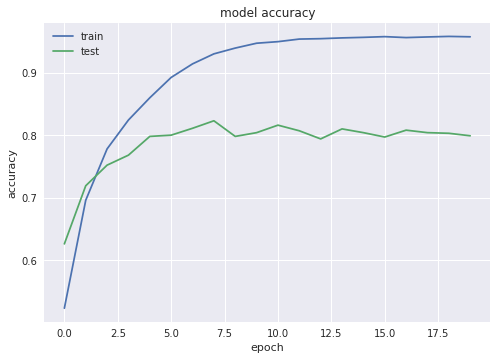

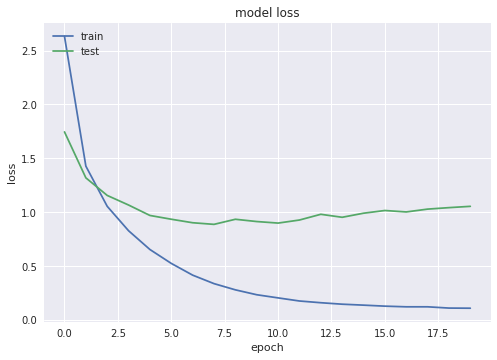

In [0]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/9
 1/16 [>.............................] - ETA: 0s - loss: 3.8039 - accuracy: 0.1289 4/16 [======>.......................] - ETA: 0s - loss: 3.4921 - accuracy: 0.3999 7/16 [============>.................] - ETA: 0s - loss: 3.1449 - accuracy: 0.450610/16 [=================>............] - ETA: 0s - loss: 2.8762 - accuracy: 0.482812/16 [=====================>........] - ETA: 0s - loss: 2.7104 - accuracy: 0.510314/16 [=========================>....] - ETA: 0s - loss: 2.5887 - accuracy: 0.526616/16 [==============================] - 1s 34ms/step - loss: 2.5085 - accuracy: 0.5367 - val_loss: 1.6729 - val_accuracy: 0.6310
Epoch 2/9
 1/16 [>.............................] - ETA: 0s - loss: 1.6721 - accuracy: 0.6738 3/16 [====>.........................] - ETA: 0s - loss: 1.5641 - accuracy: 0.6829 5/16 [========>.....................] - ETA: 0s - loss: 1.4924 - accuracy: 0.6941 7/16 [============>.................] - ETA: 0s - loss: 1.4636 - accuracy: 0.6922 9/16 [===============>..............] - ETA: 0s - loss: 1.4483 - accuracy: 0.691811/16 [===================>..........] - ETA: 0s - loss: 1.4347 - accuracy: 0.693714/16 [=========================>....] - ETA: 0s - loss: 1.3968 - accuracy: 0.7002

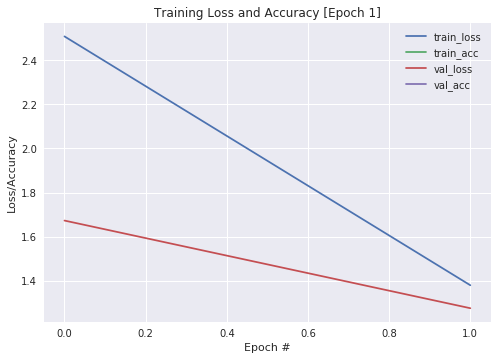

16/16 [==============================] - 1s 42ms/step - loss: 1.3794 - accuracy: 0.7047 - val_loss: 1.2752 - val_accuracy: 0.7160
Epoch 3/9
 1/16 [>.............................] - ETA: 0s - loss: 1.1429 - accuracy: 0.7480 3/16 [====>.........................] - ETA: 0s - loss: 1.0105 - accuracy: 0.7780 5/16 [========>.....................] - ETA: 0s - loss: 1.0213 - accuracy: 0.7746 7/16 [============>.................] - ETA: 0s - loss: 1.0240 - accuracy: 0.775910/16 [=================>............] - ETA: 0s - loss: 1.0289 - accuracy: 0.776813/16 [=======================>......] - ETA: 0s - loss: 1.0311 - accuracy: 0.777816/16 [==============================] - ETA: 0s - loss: 1.0263 - accuracy: 0.7799

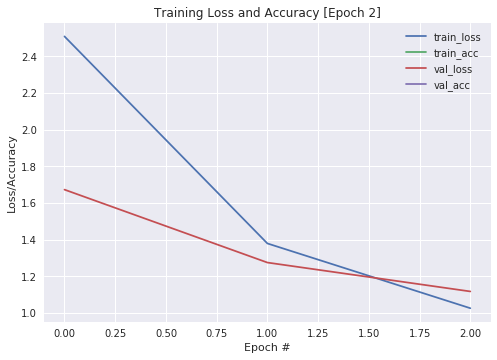

16/16 [==============================] - 1s 44ms/step - loss: 1.0263 - accuracy: 0.7799 - val_loss: 1.1177 - val_accuracy: 0.7580
Epoch 4/9
 1/16 [>.............................] - ETA: 0s - loss: 0.7977 - accuracy: 0.8418 4/16 [======>.......................] - ETA: 0s - loss: 0.8355 - accuracy: 0.8281 7/16 [============>.................] - ETA: 0s - loss: 0.8055 - accuracy: 0.8292 9/16 [===============>..............] - ETA: 0s - loss: 0.8183 - accuracy: 0.825111/16 [===================>..........] - ETA: 0s - loss: 0.8157 - accuracy: 0.825814/16 [=========================>....] - ETA: 0s - loss: 0.8143 - accuracy: 0.8266

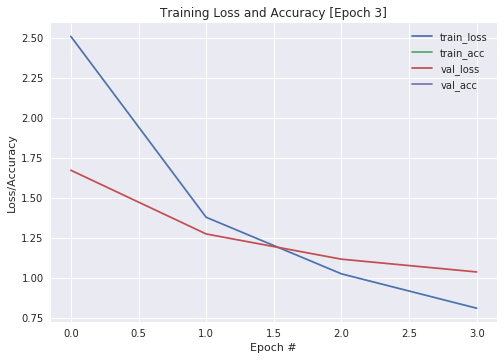

16/16 [==============================] - 1s 38ms/step - loss: 0.8116 - accuracy: 0.8262 - val_loss: 1.0380 - val_accuracy: 0.7730
Epoch 5/9
 1/16 [>.............................] - ETA: 0s - loss: 0.6984 - accuracy: 0.8457 3/16 [====>.........................] - ETA: 0s - loss: 0.6760 - accuracy: 0.8620 6/16 [==========>...................] - ETA: 0s - loss: 0.6588 - accuracy: 0.8610 9/16 [===============>..............] - ETA: 0s - loss: 0.6456 - accuracy: 0.863712/16 [=====================>........] - ETA: 0s - loss: 0.6331 - accuracy: 0.867015/16 [===========================>..] - ETA: 0s - loss: 0.6393 - accuracy: 0.8660

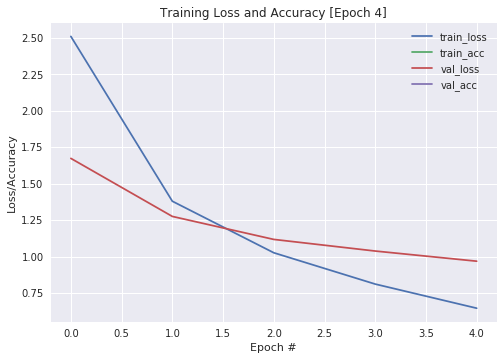

16/16 [==============================] - 1s 39ms/step - loss: 0.6464 - accuracy: 0.8654 - val_loss: 0.9685 - val_accuracy: 0.8080
Epoch 6/9
 1/16 [>.............................] - ETA: 0s - loss: 0.4655 - accuracy: 0.9316 4/16 [======>.......................] - ETA: 0s - loss: 0.5092 - accuracy: 0.9028 7/16 [============>.................] - ETA: 0s - loss: 0.5069 - accuracy: 0.899310/16 [=================>............] - ETA: 0s - loss: 0.5192 - accuracy: 0.892813/16 [=======================>......] - ETA: 0s - loss: 0.5141 - accuracy: 0.8932

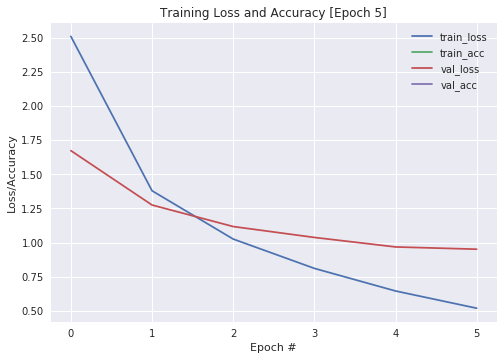

16/16 [==============================] - 1s 34ms/step - loss: 0.5203 - accuracy: 0.8900 - val_loss: 0.9519 - val_accuracy: 0.7870
Epoch 7/9
 1/16 [>.............................] - ETA: 0s - loss: 0.4457 - accuracy: 0.9141 3/16 [====>.........................] - ETA: 0s - loss: 0.4548 - accuracy: 0.9023 5/16 [========>.....................] - ETA: 0s - loss: 0.4239 - accuracy: 0.9105 8/16 [==============>...............] - ETA: 0s - loss: 0.4246 - accuracy: 0.910911/16 [===================>..........] - ETA: 0s - loss: 0.4183 - accuracy: 0.912113/16 [=======================>......] - ETA: 0s - loss: 0.4133 - accuracy: 0.913315/16 [===========================>..] - ETA: 0s - loss: 0.4106 - accuracy: 0.9139

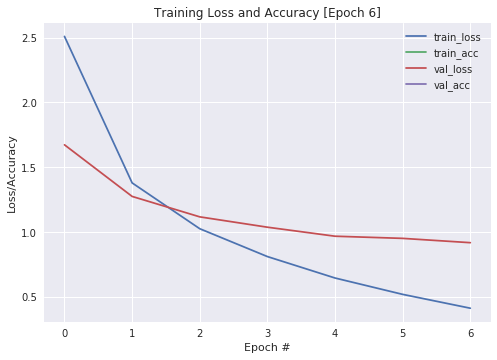

16/16 [==============================] - 1s 55ms/step - loss: 0.4137 - accuracy: 0.9134 - val_loss: 0.9187 - val_accuracy: 0.8170
Epoch 8/9
 1/16 [>.............................] - ETA: 0s - loss: 0.4051 - accuracy: 0.9102 4/16 [======>.......................] - ETA: 0s - loss: 0.3326 - accuracy: 0.9219 7/16 [============>.................] - ETA: 0s - loss: 0.3370 - accuracy: 0.923310/16 [=================>............] - ETA: 0s - loss: 0.3393 - accuracy: 0.924412/16 [=====================>........] - ETA: 0s - loss: 0.3399 - accuracy: 0.924815/16 [===========================>..] - ETA: 0s - loss: 0.3383 - accuracy: 0.9251

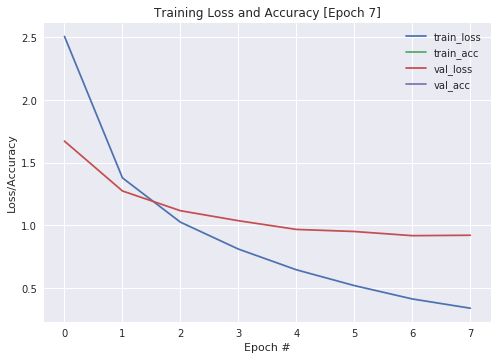

16/16 [==============================] - 1s 36ms/step - loss: 0.3399 - accuracy: 0.9250 - val_loss: 0.9220 - val_accuracy: 0.8040
Epoch 9/9
 1/16 [>.............................] - ETA: 0s - loss: 0.2563 - accuracy: 0.9551 4/16 [======>.......................] - ETA: 0s - loss: 0.2834 - accuracy: 0.9414 7/16 [============>.................] - ETA: 0s - loss: 0.2737 - accuracy: 0.943110/16 [=================>............] - ETA: 0s - loss: 0.2799 - accuracy: 0.938913/16 [=======================>......] - ETA: 0s - loss: 0.2783 - accuracy: 0.9378

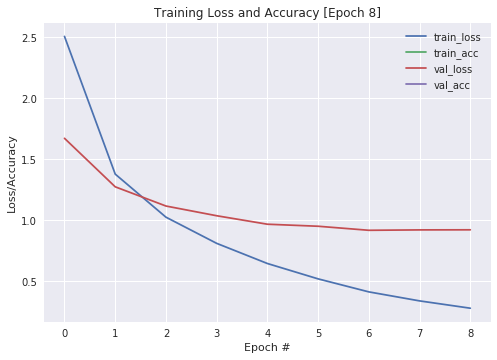

16/16 [==============================] - 1s 37ms/step - loss: 0.2798 - accuracy: 0.9381 - val_loss: 0.9227 - val_accuracy: 0.8120

In [0]:
## Re-train (from scratch) network for 9 epochs
model = Sequential()
model.add(Dense(64, activation='relu',input_dim=10000))
model.add(Dense(64, activation='relu'))
model.add(Dense(46, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(train_data_vec, 
                    train_labels_vec,
                    epochs=9,
                    batch_size=512,
                    validation_data=(val_data_vec,val_labels_vec),
                    callbacks = [plot_losses])

## Part 3: Evaluate

After the model is fitted, we can call it to make predictions on our test data. 
Here, we perform a multilabel classification, so the NN outputs a set of probabilities.

In [0]:
prediction_item = 1
proba_set = model.predict(test_data_vec[:prediction_item, :])
proba_set

Out[16]: array([[5.5077820e-05, 7.3272102e-05, 3.9521077e-05, 3.2619479e-01,
 6.4901131e-01, 2.1951558e-04, 8.0113001e-05, 7.4322837e-05,
 1.4834213e-03, 4.3853950e-05, 7.0369933e-05, 1.0706419e-03,
 6.0550890e-05, 3.6083098e-04, 1.5849959e-04, 2.0864172e-05,
 3.7768325e-03, 1.5400564e-04, 7.0842900e-05, 3.1727608e-03,
 1.0042099e-02, 7.1717217e-04, 1.7765882e-04, 2.2260626e-04,
 2.7839664e-05, 2.2510303e-06, 3.5124634e-05, 1.7449212e-04,
 5.2415471e-05, 3.0502747e-04, 2.1368131e-04, 5.4902557e-05,
 4.2736037e-06, 9.7468364e-05, 2.4070532e-05, 1.9895182e-05,
 2.2883157e-04, 1.8691388e-04, 1.8444467e-05, 5.6316430e-04,
 1.1219593e-05, 5.9251324e-04, 6.1302776e-06, 1.7447057e-05,
 9.1574275e-06, 3.8476392e-06]], dtype=float32)

Then, it attributes the class to the item, based on the max of the set of probabilities, for each element.

In [0]:
print(f'We can see that the first test_item was attributed to the class {np.argmax(proba_set, axis=-1)}. \nIts actual class is {test_labels[prediction_item-1]}.')

We can see that the first test_item was attributed to the class [4]. 
Its actual class is 3.

Our dataset is pretty big, so we can not afford the manual comparison. We use the framework's built-in methods to get our results in terms of accuracy.

In [0]:
## Metrics
metrics = model.evaluate(test_data_vec, test_labels_vec)
#accuracy
print("accuracy is %.2f, Error rate is %.2f " % (metrics[1], 1 - metrics[1]))

1/71 [..............................] - ETA: 0s - loss: 0.7392 - accuracy: 0.812535/71 [=============>................] - ETA: 0s - loss: 0.9805 - accuracy: 0.781261/71 [========================>.....] - ETA: 0s - loss: 0.9993 - accuracy: 0.782871/71 [==============================] - 0s 2ms/step - loss: 1.0171 - accuracy: 0.7778
accuracy is 0.78, Error rate is 0.22

In [0]:
## Predictions
predictions = np.argmax(model.predict(test_data_vec), axis=-1)
totalmisses = sum(test_labels != predictions)
totalmisses

Out[19]: 499

Out[20]:

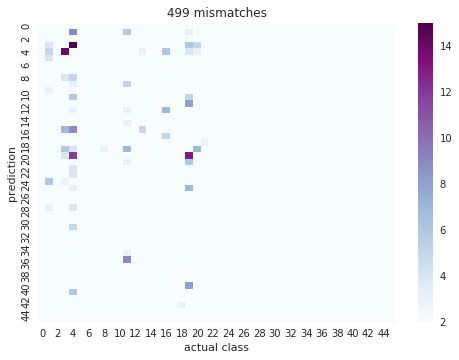

Text(51.0, 0.5, 'prediction')

In [0]:
## Confusion Matrix
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns

cm = confusion_matrix(test_labels[test_labels!=predictions], predictions[test_labels!=predictions])
sns.heatmap(cm,cmap="BuPu",vmin=2, vmax=15)

# Add title and axis names
plt.title( (str(totalmisses) + " mismatches") )
plt.xlabel('actual class')
plt.ylabel('prediction')


We outputed above a confusion matrix, but only for mismatches. In common cases, we also can output a confusion matrix for the whole dataset, to analyze where the algorithm gets confused. In our case, as we have "big" data.

As classes 3, 4 are the most represented, the neural network tends to classify a majority of articles as category 3/4, to retrieve the statistical distribution it saw.

Out[21]:

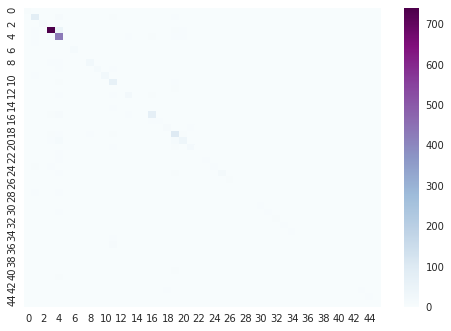

<matplotlib.axes._subplots.AxesSubplot at 0x7f4a54181bd0>

In [0]:
cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm,cmap="BuPu")

In [0]:
precision, recall, fscore, _ = precision_recall_fscore_support(test_labels, predictions)

/databricks/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))

In [0]:
class_of_interest = 3
precision_class_of_interest = precision[class_of_interest]
recall_class_of_interest = recall[class_of_interest]
print(precision_class_of_interest, recall_class_of_interest)

0.9390862944162437 0.9102091020910209

### Conclusion

In this notebook, we defined a simple dense neural network for multilabel classification.
We extracted & preprocessed the data before feeding it to the NN. We evaluated its performances, as a whole and for the most represented class.
To go further, you can visit Tensorflow or Keras package site.